# **CSMODEL**

Phase 1 - Group 5

Members:


*   De Jesus, Andrei Zarmin D.
*   Gonzales, Daniel Angelo D.
*   Person, Linus Carl G.

# **1. Dataset Representation**



*   About the Dataset
    
    This data contains various info and stats on Formula 1, including race details, race results, drivers, constructors, circuits and more spanning 7 decades. All these could help us further understand what factors can affect race results. The version that will be used was last updated back in January 29, 2025 and contains data for Formula 1 World Championships from 1950 to 2024. It has to be said though that this dataset is constantly being updated as more Formula 1 World Championships and races take place. This data is also chronologically dependent, knowing the attribute of time.


*   Collection Process and its Implications

    The collection of data was done by Rohan Rao, also known as Vopani, a Quadruple Kaggle Grandmaster and post-graduate in Applied Statistics from IIT-Bombay. For this particular dataset, though it does offer some historical overview, particular methodologies have not been explicitly detailed. This dataset however, was sourced from https://ergast.com/mrd/, a reputable motorsport database. The data presented from here is presumed to be the most recent, most up-to-date data.

*   Structure of the Dataset File

    This data is made of multiple interrelated CSV files. Key files include "races.csv," "drivers.csv," "constructors.csv," "circuits.csv," and "results.csv." Each row represents individual records. This includes race events, where they took place, drivers and their results, constructors and their results, circuit locations and race outcomes, among other things.

*   About the Variables

    This dataset has 120 variables, all of which are related to the Formula 1 World Championship. Some specifics include constructor name, constructor nationality, driver name, driver nationality, points a racer has gained, a constructor's ranking among other things. The DataFrame used mostly consists of numerical and string values.


In [1]:
# import libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import ttest_rel
 
folder_path = "./datasets"
var_count = 0
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    if os.path.isfile(file_path):
        # df for displaying purposes
        df = pd.read_csv(file_path)
        var_count += df.shape[1]
        print(df.info())
print(f"========================================")
print(f"Total variables in data set: {var_count}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   statusId  139 non-null    int64 
 1   status    139 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11371 entries, 0 to 11370
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   raceId        11371 non-null  int64 
 1   driverId      11371 non-null  int64 
 2   stop          11371 non-null  int64 
 3   lap           11371 non-null  int64 
 4   time          11371 non-null  object
 5   duration      11371 non-null  object
 6   milliseconds  11371 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 622.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ---

# **2. Data Cleaning**

### **Data Cleaning for EDA Q1**

In [2]:
# data cleaning for EDA Question #1
# read relevant data sets
results_df = pd.read_csv("./datasets/results.csv")
constructor_df = pd.read_csv("./datasets/constructors.csv")
lap_times_df = pd.read_csv("./datasets/lap_times.csv")
drivers_df = pd.read_csv("./datasets/drivers.csv")
races_df = pd.read_csv("./datasets/races.csv")

# drop unnecesary columns
results_df = results_df.loc[:, :"constructorId"]
constructor_df.drop(['url', 'constructorRef'], axis=1, inplace=True)
drivers_df.drop(['driverRef', 'number', 'code', 'dob', 'nationality', 'url'], axis=1, inplace=True)
races_df = races_df[['raceId', 'year', 'name']]
# rename for clarity
lap_times_df.rename(columns={'time': 'lap_time'}, inplace=True)
constructor_df.rename(columns={'name': 'constructor_name'}, inplace=True) 
constructor_df.rename(columns={'nationality': 'constructor_origin'}, inplace=True)


# MERGING RESULTS WITH CONSTRUCTOR DATA
results_constructor = pd.merge(results_df, constructor_df, on="constructorId", how="left")
# MERGING DRIVERS WITH RESULT AND CONSTRUCTOR DATA
rcd_df = pd.merge(results_constructor, drivers_df, on="driverId", how="left")
# MERGE LAPTIME WITH THE Result Constructor Data DF
new_df = pd.merge(lap_times_df, rcd_df, on=["raceId", "driverId"], how="left")
# MERGE NEW DF WITH OTHER NEWLY MERGED DF's
complete_df = pd.merge(races_df, new_df, on="raceId", how="left")

# add laptime in seconds table
complete_df["laptime_seconds"] = complete_df["milliseconds"] / 1000

# display final data frame
print(complete_df)

        raceId  year                   name  driverId   lap  position  \
0            1  2009  Australian Grand Prix       1.0   1.0      13.0   
1            1  2009  Australian Grand Prix       1.0   2.0      12.0   
2            1  2009  Australian Grand Prix       1.0   3.0      11.0   
3            1  2009  Australian Grand Prix       1.0   4.0      10.0   
4            1  2009  Australian Grand Prix       1.0   5.0      10.0   
...        ...   ...                    ...       ...   ...       ...   
589657    1144  2024   Abu Dhabi Grand Prix     857.0  54.0      10.0   
589658    1144  2024   Abu Dhabi Grand Prix     857.0  55.0      10.0   
589659    1144  2024   Abu Dhabi Grand Prix     857.0  56.0      10.0   
589660    1144  2024   Abu Dhabi Grand Prix     857.0  57.0      10.0   
589661    1144  2024   Abu Dhabi Grand Prix     857.0  58.0      10.0   

        lap_time  milliseconds  resultId  constructorId constructor_name  \
0       1:49.088      109088.0    7573.0       

### **Data Cleaning for EDA Q2**

In [3]:
# data cleaning for EDA Question #2
# read relevant data sets for pit stop data cleaning
races = pd.read_csv("./datasets/races.csv")
pit_stops = pd.read_csv("./datasets/pit_stops.csv")
drivers = pd.read_csv("./datasets/drivers.csv")

# clean to include only the 2023 and 2024 seasons
filtered_races = races[races["year"].isin([2023, 2024])]
# join datasets
pit_stop_df = filtered_races.merge(pit_stops, on="raceId", how="left").merge(drivers, on="driverId", how="left")

# Drop unnecessary columns
columns_to_remove = [
    "raceId", "circuitId", "date", "time_x", "url_x", "time_y",
    "milliseconds", "number", "forename", "surname", "nationality",
    "url_y", "driverId", "code", "dob"
]
columns_to_remove += [
    # this is a shorthand method to remove columns with a similar substring
    col for col in pit_stop_df.columns if "fp" in col.lower() or "quali" in col.lower() or "sprint" in col.lower()
]
pit_stop_df = pit_stop_df.drop(columns=columns_to_remove, errors="ignore")

# find unique drivers
# pit_stop_df["driverRef"].unique()

# add missing constructor information
driver_team_mapping = {
    "max_verstappen": "Red Bull", "perez": "Red Bull", "leclerc": "Ferrari",
    "sainz": "Ferrari", "hamilton": "Mercedes", "russell": "Mercedes",
    "norris": "McLaren", "piastri": "McLaren", "alonso": "Aston Martin",
    "stroll": "Aston Martin", "ocon": "Alpine", "gasly": "Alpine",
    "doohan": "Alpine", "bottas": "Sauber", "zhou": "Sauber",
    "kevin_magnussen": "Haas", "hulkenberg": "Haas", "bearman" : "Haas",
    "tsunoda": "RB", "ricciardo": "RB", "de_vries" : "RB",
    "lawson" : "RB", "albon": "Williams", "sargeant": "Williams",
    "colapinto": "Williams"
}
pit_stop_df["team"] = pit_stop_df["driverRef"].map(driver_team_mapping)

# constructor results data cleaning
constructors = pd.read_csv("./datasets/constructors.csv")
constructor_standings = pd.read_csv("./datasets/constructor_standings.csv")

# find the last race of each year
final_races = filtered_races.groupby("year")["raceId"].max().reset_index()

constructor_standings_df = constructor_standings.merge(final_races, on="raceId")

# merge with constructors data
constructor_standings_df = constructor_standings_df.merge(constructors, on="constructorId")

columns_to_remove = [
    "constructorStandingsId", "raceId", "constructorId", "constructorRef",
    "url", "positionText", "nationality"
]

# drop unnecessary columns
constructor_standings_df = constructor_standings_df.drop(columns=columns_to_remove, errors="ignore")

# display cleaned data frames
print(pit_stop_df)
print(constructor_standings_df)

      year  round                  name  stop  lap duration        driverRef  \
0     2023      1    Bahrain Grand Prix     1    9   25.885            gasly   
1     2023      1    Bahrain Grand Prix     1   10   32.766           norris   
2     2023      1    Bahrain Grand Prix     1   10   25.267          tsunoda   
3     2023      1    Bahrain Grand Prix     1   11   25.399           bottas   
4     2023      1    Bahrain Grand Prix     1   11   25.054            albon   
...    ...    ...                   ...   ...  ...      ...              ...   
1732  2024     24  Abu Dhabi Grand Prix     2   32   22.053           stroll   
1733  2024     24  Abu Dhabi Grand Prix     1   34   21.694         hamilton   
1734  2024     24  Abu Dhabi Grand Prix     2   37   22.437           alonso   
1735  2024     24  Abu Dhabi Grand Prix     2   39   28.765             zhou   
1736  2024     24  Abu Dhabi Grand Prix     4   55   22.090  kevin_magnussen   

              team  
0           Alpine

### **Data Cleaning for EDA Q3**

In [4]:
# data cleaning for EDA Question #3
# read relevant datasets
results_df = pd.read_csv("./datasets/results.csv")
qualifying_df = pd.read_csv("./datasets/qualifying.csv")
constructors_df = pd.read_csv("./datasets/constructors.csv")
races_df = pd.read_csv("./datasets/races.csv")

# drop unneccessary columns
all_variables = results_df.columns.tolist()
exclude_variables = ['resultId', 'raceId', 'driverId', 'constructorId', 'positionOrder', 'statusId']
var_to_drop = list(set(all_variables) - set(exclude_variables))
results2_df = results_df.drop(set(var_to_drop), axis='columns')

# merge data data
df = results2_df.merge(qualifying_df[["raceId", "driverId", "constructorId", "position"]], on=["raceId", "driverId", "constructorId"])
df = df.merge(races_df[["year", "raceId"]], on="raceId")
df = df.merge(constructors_df[["constructorId", "name"]], on="constructorId")
df = df[df['year'] >= 2023]
df.rename(columns={"positionOrder": "position_finishing", "position": "position_qualifying"}, inplace=True)
eda_three = df
# display completed dataframe
print(eda_three)

       resultId  raceId  driverId  constructorId  position_finishing  \
9565      25846    1098       830              9                   1   
9566      25847    1098       815              9                   2   
9567      25848    1098         4            117                   3   
9568      25849    1098       832              6                   4   
9569      25850    1098         1            131                   5   
...         ...     ...       ...            ...                 ...   
10479     26760    1144       825            210                  16   
10480     26761    1144       859            215                  17   
10481     26762    1144       822             15                  18   
10482     26763    1144       861              3                  19   
10483     26764    1144       815              9                  20   

       statusId  position_qualifying  year          name  
9565          1                    1  2023      Red Bull  
9566          1  

# **3. Exploratory Data Analysis**

#### **EDA QUESTION 1: *IS THERE A DIFFERENCE IN THE LAP TIMES OF CONSTRUCTORS IN THE 2023 AND 2024 SEASON?***
Summary Statistics:

  constructor_name  mean_laptime_2023  mean_laptime_2024  median_laptime_2023  \
0   Alpine F1 Team          98.201935          95.463766              90.3755   
1     Aston Martin          98.919018          95.564487              89.0380   
2          Ferrari          96.276328          94.878616              90.9330   
3     Haas F1 Team          98.816163          94.483306              92.0850   
4          McLaren          98.475085          94.693976              88.0035   
5         Mercedes          98.042532          94.849137              90.6515   
6         Red Bull          99.170085          94.739496              89.3935   
7         Williams          97.129798          95.110725              91.9560   

   median_laptime_2024  
0              89.5040  
1              89.8725  
2              88.4730  
3              90.8300  
4              87.9310  
5              87.7450  
6              89.7500  
7              90.1480  


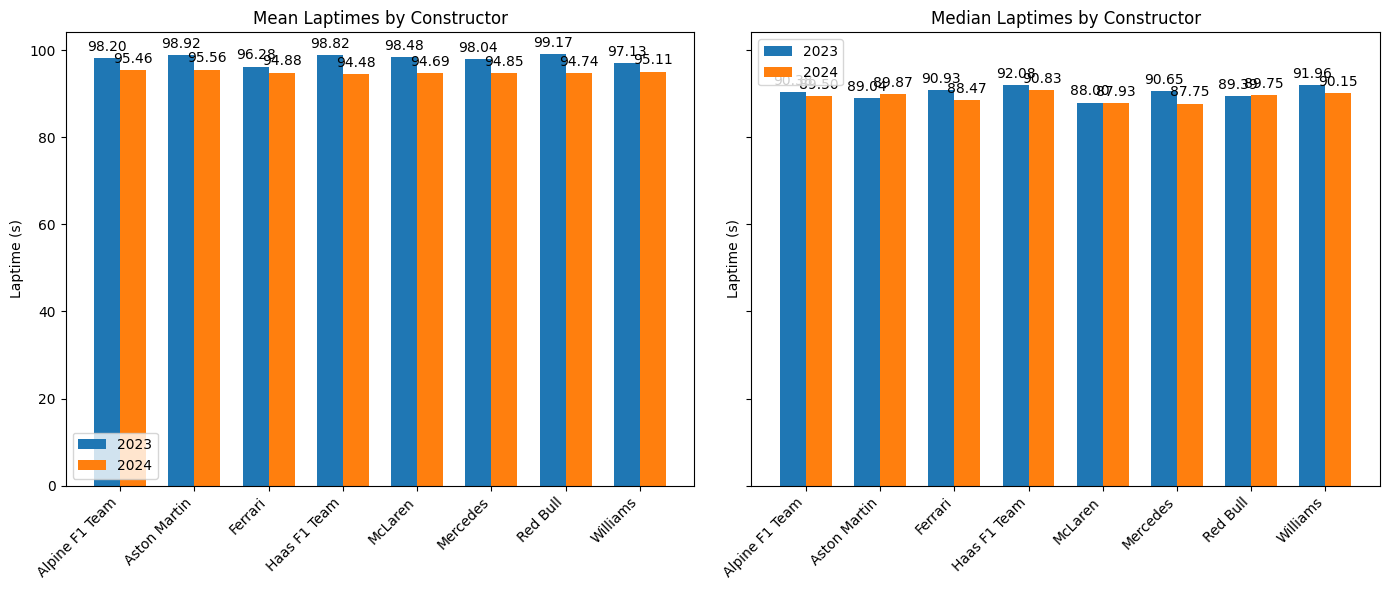

In [5]:
df_2023 = complete_df[complete_df["year"] == 2023]

# Compute mean and median of laptime_seconds per constructor in 2023
constructor_stats_2023 = (
    df_2023
    .groupby("constructor_name")["laptime_seconds"]
    .agg(["mean", "median"])
    .reset_index()
)
constructor_stats_2023.columns = ["constructor_name", "mean_laptime_2023", "median_laptime_2023"]

# FILTER 2024 DATA
df_2024 = complete_df[complete_df["year"] == 2024]

# Compute mean and median of laptime_seconds per constructor in 2024
constructor_stats_2024 = (
    df_2024
    .groupby("constructor_name")["laptime_seconds"]
    .agg(["mean", "median"])
    .reset_index()
)
constructor_stats_2024.columns = ["constructor_name", "mean_laptime_2024", "median_laptime_2024"]

# only merge where teams participated in both of the season
constructor_stats = pd.merge(
    constructor_stats_2023,
    constructor_stats_2024,
    on="constructor_name",
    how="inner"
)

# fix order of columns
constructor_stats = constructor_stats[
    ["constructor_name",
     "mean_laptime_2023", "mean_laptime_2024",
     "median_laptime_2023", "median_laptime_2024"]
]

# display constructor statistics table
print(constructor_stats)

constructors = constructor_stats["constructor_name"]
mean_2023 = constructor_stats["mean_laptime_2023"]
mean_2024 = constructor_stats["mean_laptime_2024"]
median_2023 = constructor_stats["median_laptime_2023"]
median_2024 = constructor_stats["median_laptime_2024"]

x = np.arange(len(constructors))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Subplot 1: Mean
rects1_1 = ax1.bar(x - width/2, mean_2023, width, label='2023')
rects1_2 = ax1.bar(x + width/2, mean_2024, width, label='2024')

ax1.set_ylabel('Laptime (s)')
ax1.set_title('Mean Laptimes by Constructor')
ax1.set_xticks(x)
ax1.set_xticklabels(constructors, rotation=45, ha='right')
ax1.legend()

# Annotate
for rects in [rects1_1, rects1_2]:
    for rect in rects:
        height = rect.get_height()
        ax1.annotate(f'{height:.2f}',
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom')

# Subplot 2: Median
rects2_1 = ax2.bar(x - width/2, median_2023, width, label='2023')
rects2_2 = ax2.bar(x + width/2, median_2024, width, label='2024')

ax2.set_ylabel('Laptime (s)')
ax2.set_title('Median Laptimes by Constructor')
ax2.set_xticks(x)
ax2.set_xticklabels(constructors, rotation=45, ha='right')
ax2.legend()

# Annotate
for rects in [rects2_1, rects2_2]:
    for rect in rects:
        height = rect.get_height()
        ax2.annotate(f'{height:.2f}',
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom')

# display data visualization
plt.tight_layout()
plt.show()

**FOR EDA 1:** IS THERE A DIFFERENCE IN THE LAP TIMES OF CONSTRUCTORS IN THE 2023 AND 2024 SEASON?
* ***Ho:*** There is no statistically significant
difference in the lap times of constructors in the 2023 (pre-test) and 2024 (post-test) season  

* ***Ha:*** There is a statistically significant difference  in the lap times of constructors in the 2023 (pre-test) and 2024 (post-test) season

Shapiro-Wilk Test p-value: 0.72421
Differences are normally distributed (t-test is valid).


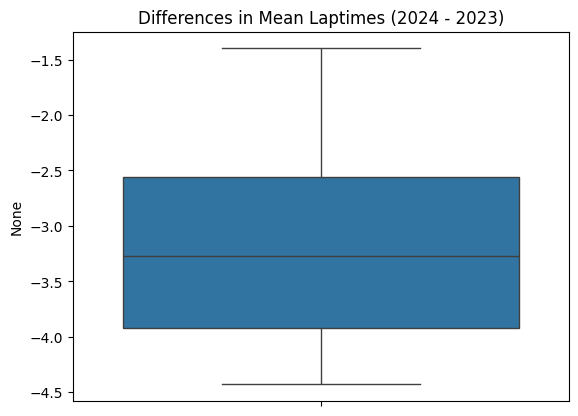

T-Statistic: 8.349854047460651
P-Value: 6.928298103739378e-05
Reject the null hypothesis: There is a significant difference in lap times between 2023 and 2024.


In [ ]:
# test for normality
from scipy.stats import shapiro
diff = mean_2024 - mean_2023
stat, p = shapiro(diff)
print(f"Shapiro-Wilk Test p-value: {p:.5f}")

if p > 0.05:
    print("Differences are normally distributed (t-test is valid).")
else:
    print("Differences are NOT normally distributed (consider Wilcoxon signed-rank test).")

# data visualization
sns.boxplot(y=diff)
plt.title("Differences in Mean Laptimes (2024 - 2023)")
plt.show()

# paired t-test
t_stat, p_value = ttest_rel(mean_2023, mean_2024)

print(f"T-Statistic: {t_stat}\n")
print(f"P-Value: {p_value}")

alpha = 0.05
if p_value > alpha:
    print("Fail to reject the null hypothesis: No significant difference in lap times between 2023 and 2024.")
else:
    print("Reject the null hypothesis: There is a significant difference in lap times between 2023 and 2024.")

**Conclusion:** Reject the null hypothesis: There is a statistically significant difference in lap times between 2023 and 2024.

#### **EDA QUESTION 2: *IS THERE A RELATIONSHIP BETWEEN A CONSTRUCTOR'S AVERAGE PIT STOP DURATION AND THEIR FINAL STANDINGS IN THE 2023 AND 2024 SEASON?***
Summary Statistics:

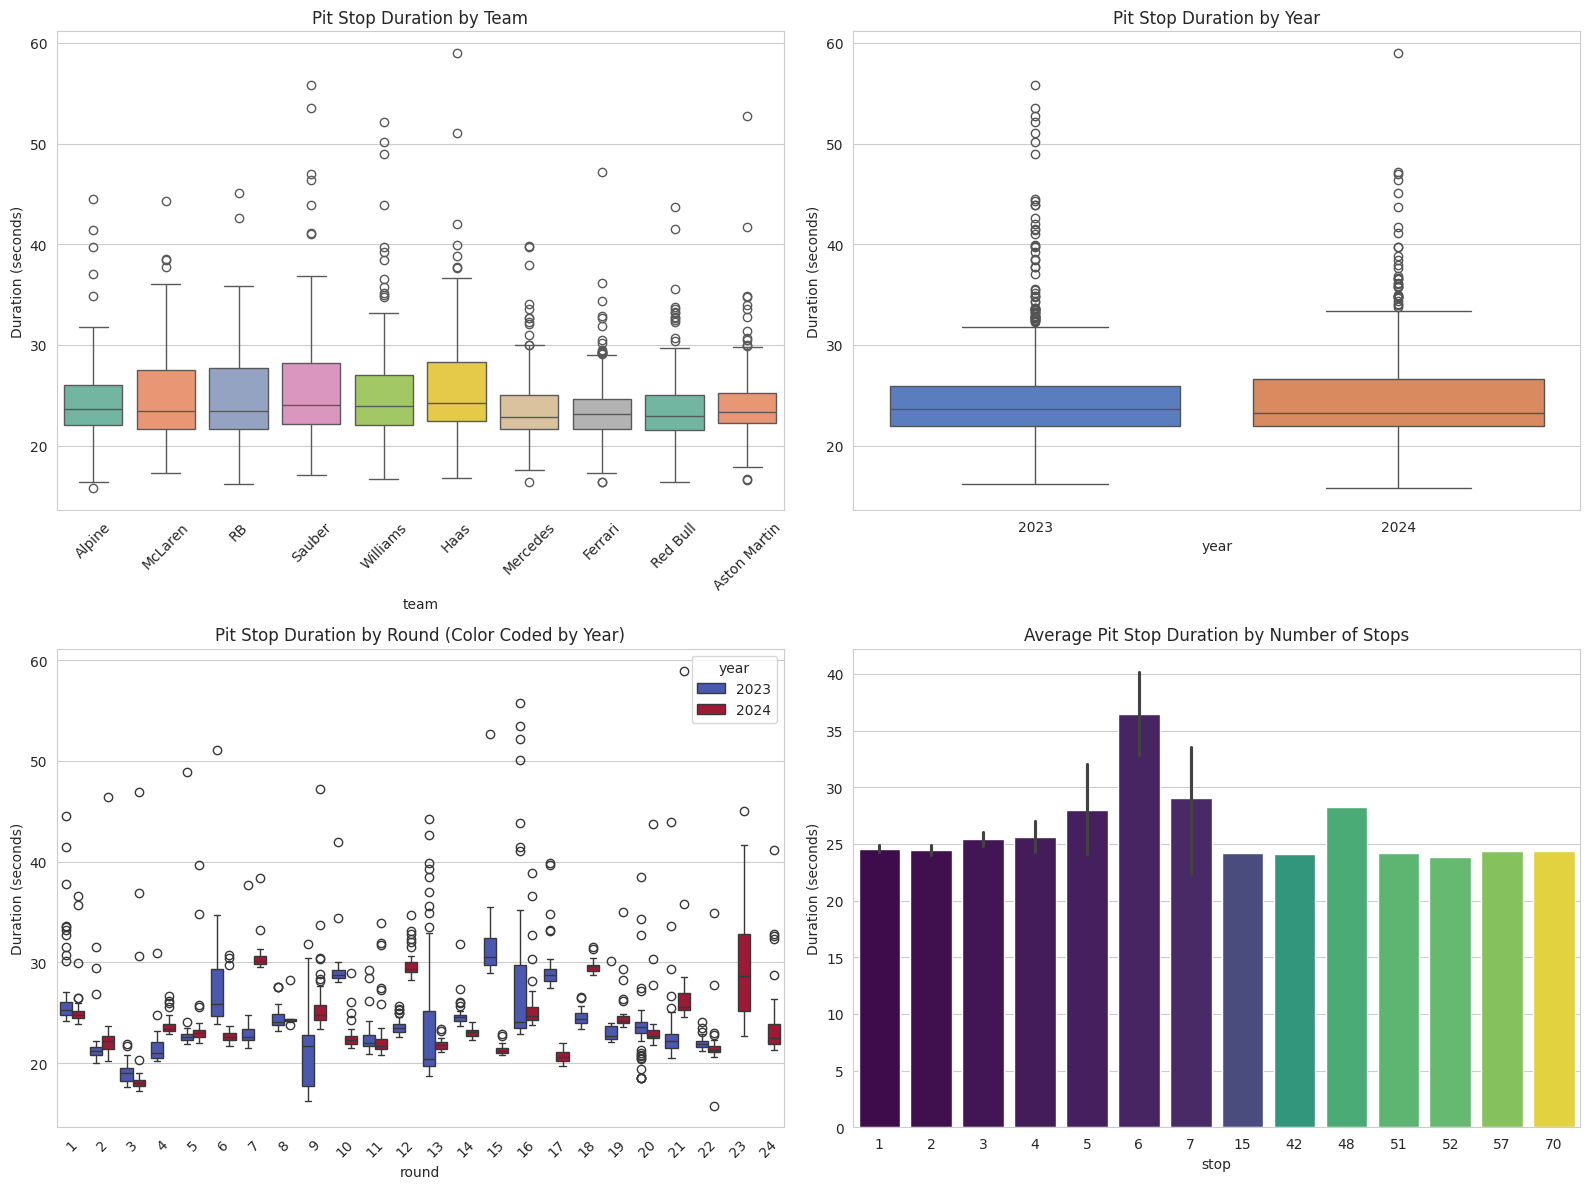

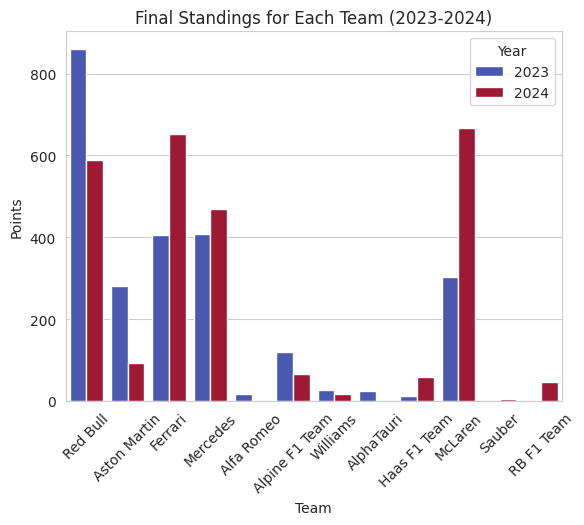

In [7]:
# convert duration to numerical
pit_stop_df["duration"] = pd.to_numeric(pit_stop_df["duration"], errors='coerce')
pit_stop_df = pit_stop_df.dropna(subset=["duration"])  # Remove invalid values

sns.set_style("whitegrid")

# create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Boxplot: Pit Stop Durations by Team
sns.boxplot(x="team", y="duration", hue="team", data=pit_stop_df, ax=axes[0, 0], palette="Set2", legend=False)
axes[0, 0].set_title("Pit Stop Duration by Team")
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].set_ylabel("Duration (seconds)")

# Pit Stop Durations by Year
sns.boxplot(x="year", y="duration", hue="year", data=pit_stop_df, ax=axes[0, 1], palette="muted", legend=False)
axes[0, 1].set_title("Pit Stop Duration by Year")
axes[0, 1].set_ylabel("Duration (seconds)")

# Pit Stop Durations by Round
sns.boxplot(x="round", y="duration", hue="year", data=pit_stop_df, ax=axes[1, 0], palette="coolwarm")
axes[1, 0].set_title("Pit Stop Duration by Round (Color Coded by Year)")
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].set_ylabel("Duration (seconds)")

# Pit Stop Durations by Number of Stops
sns.barplot(x="stop", y="duration", hue="stop", data=pit_stop_df, estimator=np.mean, ax=axes[1, 1], palette="viridis", legend=False)
axes[1, 1].set_title("Average Pit Stop Duration by Number of Stops")
axes[1, 1].set_ylabel("Duration (seconds)")

# display pitstop summary stats
plt.tight_layout()
plt.show()

# display constructor standings
sns.barplot(x="name", y="points", hue="year", data=constructor_standings_df, estimator=np.mean, palette="coolwarm")
plt.title("Final Standings for Each Team (2023-2024)")
plt.xlabel("Team")
plt.ylabel("Points")
plt.xticks(rotation=45)
plt.legend(title="Year")
plt.show()

**FOR EDA 2:** IS THERE A RELATIONSHIP BETWEEN A CONSTRUCTOR'S AVERAGE PIT STOP DURATION AND THEIR FINAL STANDINGS (POINTS) DURING THE 2023 AND 2024 SEASON?
* ***Ho:*** There is no statistically significant
relationship between the the average pitstop duration of constructors and their final standings during the 2023 and 2024 season  

* ***Ha:*** There is no statistically significant
relationship between the the average pitstop duration of constructors and their final standings during the 2023 and 2024 season

Correlation Test: Since data is normal, use Pearson
Correlation Coefficient: -0.7600
p-value: 0.0026
Reject the null hypothesis: There is a significant relationship between pit stop duration and final standings.


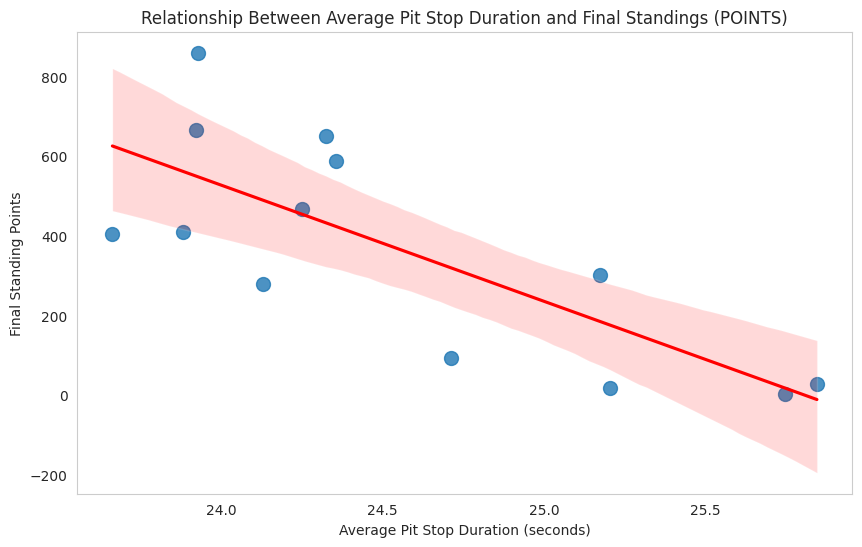

In [8]:
pit_stop_avg = pit_stop_df.groupby(['team', 'year'])['duration'].mean().reset_index()
pit_stop_avg.rename(columns={'duration': 'avg_pitstop_duration'}, inplace=True)

# merge with final standings
team_standings = constructor_standings_df[['name', 'year', 'points']].copy()
team_standings.rename(columns={'name': 'team', 'points': 'final_standing'}, inplace=True)

# fix  mismatches
set(team_standings["team"]) - set(pit_stop_avg["team"])

# merge datasets
merged_df = pit_stop_avg.merge(team_standings, on=['team', 'year'], how="inner")

# Check for normality using Shapiro-Wilk test
shapiro_pitstop = stats.shapiro(merged_df['avg_pitstop_duration'])[1]
shapiro_standings = stats.shapiro(merged_df['final_standing'])[1]

# determine correlation type
if shapiro_pitstop > 0.05 and shapiro_standings > 0.05:
    corr_test = stats.pearsonr(merged_df['avg_pitstop_duration'], merged_df['final_standing'])
    test_type = "Since data is normal, use Pearson"
else:
    corr_test = stats.spearmanr(merged_df['avg_pitstop_duration'], merged_df['final_standing'])
    test_type = "Since data is not normal, use Spearman"

# display results
print(f"Correlation Test: {test_type}")
print(f"Correlation Coefficient: {corr_test[0]:.4f}")
print(f"p-value: {corr_test[1]:.4f}")

# interpretation the results
if corr_test[1] < 0.05:
    print("Reject the null hypothesis: There is a significant relationship between pit stop duration and final standings.")
else:
    print("Fail to reject the null hypothesis: No significant relationship found.")

# visualization the correlation
plt.figure(figsize=(10,6))
sns.regplot(x="avg_pitstop_duration", y="final_standing", data=merged_df, scatter_kws={"s":100}, line_kws={"color":"red"})
plt.title("Relationship Between Average Pit Stop Duration and Final Standings (POINTS)")
plt.xlabel("Average Pit Stop Duration (seconds)")
plt.ylabel("Final Standing Points")
plt.grid()
plt.show()

**Conclusion:** Reject the null hypothesis: There is a significant relationship between pit stop duration and final standings (points).

**FOR EDA 3: IS THERE A CORRELATION BETWEEN THE QUALIFYING AND FINISHING POSITIONS OF TEAMS DURING THE 2023 and 
2024 SEASONS?**

Summary Statistics:

In [9]:
team_stats_df = df.groupby("name")[["position_qualifying", "position_finishing", "position_change"]].agg(["mean", "median", "min", "max", "std"])
team_stats_df

KeyError: "Columns not found: 'position_change'"

# **5. Research Question**

Is there a significant difference between lower-grid teams and higher-grid teams in lap times from 2023 to 2024?